In [1]:
import praw
import json
import pandas as pd
import os
import glob
import numpy as np

In [2]:
out_path ='/Users/f004p74/Documents/dartmouth/projects/conflictNarratives/aita-posts/'

#### Getting started with PRAW
Before praw can be used to scrape data, it needs us to authenticate ourselves. To do this, we need to create a read-only overall Reddit 'instance' and provide it with three pieces of information: your client_id , client_secret, and user_agent (plus your username and password).

In [3]:
#create a (general) reddit instance

reddit = praw.Reddit()

Version 7.6.0 of praw is outdated. Version 7.7.1 was released Tuesday July 11, 2023.


### Creating a Subreddit 'Instance'

To begin, we must create a subreddit 'instance' (similar to when we created the more general Reddit 'instance') by defining which subreddit we want to scrape. 

In [31]:
#scrape = reddit.subreddit('AmItheAsshole')
#scrape = reddit.subreddit('Relationships')
#scrape = reddit.subreddit('relationship_advice')
#scrape = reddit.subreddit('tifu')
scrape = reddit.subreddit('BreakUps')


### Before you Scrape

1. **Be aware of limits**: Although you can set `limit=None`, the maximum is actually 1000, which is a limitation set by Reddit directly. According to PRAW, you can try to get more than 1,000 by using the search function. 

2. **Pick your sub-category**: For each Subreddit, different categories of posts can be selectively scraped: best, hot, new, controversial, top, and rising. Here, I am only interested in collecting two categories that we will scrape on a monthly basis: new and top.

3. **Prepare for inconsistencies**: PRAW docs notes that you may see a discrepancy between what praw returns and what is actually viewable on the reddit page, because it counts deleted, removed, and spam comments.

4. **Data Handling**: If you're saving your data in a as a .JSON object, be sure to cast your "Redditor" objects as strings (e.g., do str(comment.author) for example) because otherwise, JSON doesn't know what that object is and it'll break, losing all that precious scraped data!

In [32]:
scrape_top = scrape.top(limit=1000)

In [33]:
#we ignore the AutoModerator because it's unreleated to the post's content
skip_list = ['AutoModerator']

for submission in scrape_top:
    praw_dict = {}
    submission_id = submission.id
    
    praw_dict["Submission"] = {'Title': submission.title,
                                'Sub ID': submission.id,
                               'URL': submission.url,
                              'Body': submission.selftext}
    
    with open(out_path+submission_id+'_top.json', 'w') as fp:
        json.dump(praw_dict, fp)

In [34]:
scrape_hot = scrape.hot(limit=1000)

In [35]:
#we ignore the AutoModerator because it's unreleated to the post's content
skip_list = ['AutoModerator']

for submission in scrape_hot:
    praw_dict = {}
    submission_id = submission.id
    
    praw_dict["Submission"] = {'Title': submission.title,
                                'Sub ID': submission.id,
                               'URL': submission.url,
                              'Body': submission.selftext}
    
    with open(out_path+submission_id+'_hot.json', 'w') as fp:
        json.dump(praw_dict, fp)

In [36]:
scrape_controversial = scrape.controversial(limit=1000)

In [37]:
#we ignore the AutoModerator because it's unreleated to the post's content
skip_list = ['AutoModerator']

for submission in scrape_controversial:
    praw_dict = {}
    submission_id = submission.id
    
    praw_dict["Submission"] = {'Title': submission.title,
                                'Sub ID': submission.id,
                               'URL': submission.url,
                              'Body': submission.selftext}
    
    with open(out_path+submission_id+'_controversial.json', 'w') as fp:
        json.dump(praw_dict, fp)

## Load Data for Topic Modeling

In [38]:
file_list = os.listdir(out_path)
print(len(file_list),file_list[0])

13376 176ky5x_hot.json


In [39]:
data = []

for file in file_list:
    try:
        with open(out_path+file) as f:
            json_dict = json.load(f)

        data.append(json_dict["Submission"]['Body'])
    except:
        continue

In [42]:
print(data[0])

About four years ago I (30 M) met my friend "Tom" (38 M) when we both enrolled in the same grad school program.
  

  
Tom is someone who has a lot of trouble forming close relationships to other people, and has said several times he thinks of me as one of his closest friends.
  

  
Toward the end of our program, I had mentioned that I was thinking about getting another degree that would help me in the specialization I was going into. Tom was not going into this field, but thought the specialization would be worthwhile to pursue and asked if we should do it together. I said that that sounded like a good idea. Tom said he wouldn't want to go into another degree program for at least two years after finishing our previous program, and I thought that sounded reasonable.
  

  
As we got closer to the end of our program Tom began saying that he was tired of school and academia in general.
  

  
Since we both graduated I started thinking about my next degree, and I considered picking up a 

## Text Processing & Analysis

In [43]:
import re
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from gensim.utils import simple_preprocess

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/f004p74/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /Users/f004p74/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/f004p74/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
contractions = { "ain't": "am not","aren't": "are not","can't": "cannot",
"can't've": "cannot have","'cause": "because","could've": "could have","couldn't": "could not",
"couldn't've": "could not have","didn't": "did not","doesn't": "does not","don't": "do not",
"hadn't": "had not","hadn't've": "had not have","hasn't": "has not","haven't": "have not",
"he'd": "he would","he'd've": "he would have","he'll": "he will","he's": "he is",
"how'd": "how did","how'll": "how will","how's": "how is","i'd": "i would",
"i'll": "i will","i'm": "i am","i've": "i have","isn't": "is not","it'd": "it would",
"it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam","mayn't": "may not",
"might've": "might have","mightn't": "might not","must've": "must have","mustn't": "must not",
"needn't": "need not","oughtn't": "ought not","shan't": "shall not","sha'n't": "shall not",
"she'd": "she would","she'll": "she will","she's": "she is","should've": "should have",
"shouldn't": "should not","that'd": "that would","that's": "that is","there'd": "there had",
"there's": "there is","they'd": "they would","they'll": "they will","they're": "they are",
"they've": "they have","wasn't": "was not","we'd": "we would","we'll": "we will","we're": "we are",
"we've": "we have","weren't": "were not","what'll": "what will","what're": "what are",
"what's": "what is","what've": "what have","where'd": "where did","where's": "where is","who'll": "who will",
"who's": "who is","won't": "will not","wouldn't": "would not","you'd": "you would",
"you'll": "you will","you're": "you are"}

stopwords_list = stopwords.words('english')
stopwords_list.extend(['aita', 'asshole', 'reddit','subreddit','aitah','post',
                       'poster','link','original','lurker','edit','amitheasshole','x200b','tifu',
                      'relationships','breakup'])

In [53]:
clean_list = []

for i in data:
    text = i.lower() # convert all text to lowercase
    text = text.split() #separates the block of text to individual words
    new_text = []
    for word in text: # converts contractions to separate words
        if word in contractions:
            new_text.append(contractions[word])
        else:
            new_text.append(word)
    
    text = " ".join(new_text)
    
    # Remove special characters and punctuation
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\\', '', text)
    text = re.sub(r'&#', '', text) 

    # Tokenize each word
    text = nltk.WordPunctTokenizer().tokenize(text)

    # Lemmatize each word
    text = [nltk.stem.WordNetLemmatizer().lemmatize(token, pos='v') for token in text if len(token)>1]
    
    # Remove stop words
    text = [x for x in text if x not in stopwords_list]
    
    # Convert the list back into a string.
    text = ' '.join(map(str, text))
    
    clean_list.append(text)

### Removing Named Entities

In [54]:
import spacy
from spacy import displacy
from spacy import tokenizer
nlp = spacy.load('en_core_web_sm')

Spacy doesn't seem to be doing a great job of taking out all the common English names. As I sift through the data, I am picking out some names that I notice to exclude from the dataset (see ents_list)

In [82]:
ents_removed = []

for i in clean_list:
    doc = nlp(i)
    ents = doc.ents
    ents_list = ['adam','leo','connor','kate','nia','stella','derek', 'leah',
                 'julie','jason','lisa','leah','jake','jess','ashley','jeremy',
                 'emma','samantha','ann','tony','amy','annie','kayla','xander','ann',
                 'anna','josh','jon','liam','jane','dave','jack','mia','megan','ted','elle',
                 'alexis','hayley','anne','katie','john','lacey','matt','sara',
                 'melissa','ellie','olivia','fred','pete','becca','britney','ella',
                'brittney','daniella','kylie','amber','zane','zoey','mary','kat',
                 'felix','rachel','alexandra','sofia','vanessa','mara','debra']

    for e in ents:
        if e.label_ == "PERSON":
            ents_list.append(str(e))
        else:
            ents_list.append(str(e))

    sep_words = i.split()
    ent_filter = []
    
    for word in sep_words:
        if word not in ents_list:
            ent_filter.append(word)
        else:
            continue
    
    ent_filter = ' '.join(map(str, ent_filter))
    ents_removed.append(ent_filter)

In [83]:
all_words = []

for i in ents_removed:
    word_list = i.split()
    for word in word_list:
        all_words.append(word)

print(len(all_words))

2077416


### Saving lists of posts as csv

In [84]:
df = pd.DataFrame(ents_removed)
df.to_csv("/Users/f004p74/Documents/dartmouth/projects/conflictNarratives/aita-posts/text_dataset.csv")

# Modeling

In [112]:
import gensim.corpora as corpora
from gensim.models.coherencemodel import CoherenceModel

## Reading in the data for modeling

In [113]:
df = pd.read_csv('/Users/f004p74/Documents/dartmouth/projects/conflictNarratives/aita-posts/text_dataset.csv')
text = pd.Series(df['0'])

ents_removed = []

for i in text:
    ents_removed.append(str(i))
    
all_words = []

for e in ents_removed:
    word_list = str(e).split()
    for word in word_list:
        all_words.append(word)

### 4-Fold Cross Validation

In [114]:
import random

random.shuffle(ents_removed)

list_length, quarter_length = len(ents_removed),int(len(ents_removed)/4)

ranges = []

for i in range (0,list_length,quarter_length):
    ranges.append(i)

ranges

[0, 3343, 6686, 10029, 13372]

In [117]:
topic_path = "/Users/f004p74/Documents/dartmouth/projects/conflictNarratives/"

for k in range(4):
    quarter_start = ranges[k]
    quarter_stop = ranges[k+1]
    test = ents_removed[quarter_start:quarter_stop]
    train = ents_removed.copy()
    del train[quarter_start:quarter_stop]
    print("hold-out fold: //",quarter_start,":",quarter_stop,"//")
    
    # Create Corpus: Term Document Frequency - Training Dataset

    train_dataset = [str(d).split() for d in train]
    train_dictionary = gensim.corpora.Dictionary(train_dataset)

    train_corpus = []
    for text in train_dataset:
        new_text = train_dictionary.doc2bow(text)
        train_corpus.append(new_text)
    
    print("training corpus ready.")
    # Create Corpus: Term Document Frequency - Testing Dataset
    test_dataset = [str(d).split() for d in test]
    test_dictionary = gensim.corpora.Dictionary(test_dataset)

    test_corpus = []
    for text in test_dataset:
        new_text = test_dictionary.doc2bow(text)
        test_corpus.append(new_text)
        
    print("test corpus ready. Beginning LDA modeling")
    
    topics_num= 15
    
    for i in range(1,topics_num+1):
        lda_model = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                           id2word=train_dictionary,
                                           iterations=50,
                                           num_topics=i,
                                           random_state=100,
                                           eval_every=20,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
        print("LDA Model complete. Starting coherence model... ")
        
        coherence_model = CoherenceModel(model=lda_model,
                                     corpus=test_corpus, #texts only needed for sliding window measures
                                     dictionary=test_dictionary,
                                     coherence='u_mass') 

        coherence = coherence_model.get_coherence()
        
        print("Topic coherence calculated: ",coherence,"topic: ",i, "of ", topics_num)

        coherence_out = open(topic_path+"fold_"+str(k)+"_coherence_score_"+str(i)+"_topics.txt", "w")
        coherence_out.write(str(coherence))
        coherence_out.close()

hold-out fold: // 0 : 3343 //
training corpus ready.
test corpus ready. Beginning LDA modeling
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -5.606152254800891 topic:  1 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -5.387250222851632 topic:  2 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -6.357342876057236 topic:  3 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -8.049632860704117 topic:  4 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -8.439038596914326 topic:  5 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -7.845853357541066 topic:  6 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -8.568311470536782 topic:  7 of  15
LDA Model complete. Starting coherence model... 
Topic coherence calculated:  -8.929819114446229 topic:  8 

In [121]:
dfs = []

for k in range(4):
    
    score_list = []
    
    for i in range(1,topics_num):
        coherence_read = open(topic_path+"fold_"+str(k)+"_coherence_score_"+str(i)+"_topics.txt", "r")
        score_list.append(float(coherence_read.read()))

    topic_list = [int(x) for x in range(1,topics_num)]

    df = pd.DataFrame({'fold':k,'topics':topic_list, 'coherence':score_list})
    dfs.append(df)

combined_df = pd.concat(dfs, axis=0)
combined_df.head()

,fold,topics,coherence
0,0,1,-5.606152
1,0,2,-5.387250
2,0,3,-6.357343
3,0,4,-8.049633
4,0,5,-8.439039


In [128]:
average = combined_df.groupby('topics')['coherence'].mean()
average

topics
1     -5.111385
2     -5.120016
3     -5.678570
4     -6.745522
5     -8.002286
6     -7.802846
7     -8.336341
8     -9.085077
9     -9.958533
10   -11.076388
11   -11.108959
12   -11.250911
13   -11.140063
14   -11.447483
Name: coherence, dtype: float64

<AxesSubplot:xlabel='topics'>

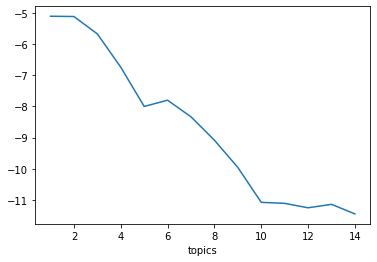

In [127]:
#df.plot.line(y='coherence', x='topics')
average.plot.line()

Local maximum appears to be around 6.

# Investigating 6 topics

In [129]:
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()

In [130]:
# Create Corpus: Term Document Frequency
dataset = [d.split() for d in ents_removed]
dictionary = gensim.corpora.Dictionary(dataset)

corpus = []
for text in dataset:
    new_text = dictionary.doc2bow(text)
    corpus.append(new_text)

In [141]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           iterations=50,
                                           num_topics=6,
                                           random_state=100, #seed
                                           eval_every=20,
                                           update_every=1, #update the model every chunk
                                           chunksize=500, #how many docs to consider at once; affects memory
                                           passes=10, #how many times the model should pass over the whole corpus
                                           alpha='auto',
                                           per_word_topics=False)

In [142]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.121570  0.026621       1        1  34.839396
0      0.179601  0.009582       2        1  27.586312
4      0.030112  0.210468       3        1  17.156000
5      0.026829 -0.130773       4        1  10.145982
3     -0.064446 -0.182452       5        1   6.438935
2     -0.293666  0.066554       6        1   3.833375, topic_info=      Term          Freq         Total Category  logprob  loglift
347    say  25650.000000  25650.000000  Default  30.0000  30.0000
107   tell  20338.000000  20338.000000  Default  29.0000  29.0000
608   work  10760.000000  10760.000000  Default  28.0000  28.0000
567   feel  14934.000000  14934.000000  Default  27.0000  27.0000
79    love   8741.000000   8741.000000  Default  26.0000  26.0000
..     ...           ...           ...      ...      ...      ...
284  leave    436.161778   8161.876458   Topic6  -5.2075   0.3322
822   yell    300.630791   1050.671643   Topic6  -5.5796   2.0101
347    say    453.691015  25650.297292   Topic6  -5.1681  -0.7735
121    ask    402.341160  11434.981638   Topic6  -5.2882  -0.0857
9     come    370.839383  10330.701557   Topic6  -5.3698  -0.0657

[492 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
113       2  0.880416       **
113       3  0.119122       **
113       4  0.000388       **
2035      2  0.995786      ---
1914      2  0.980127      .**
...     ...       ...      ...
822       6  0.286483     yell
2085      2  0.100719  younger
2085      3  0.003357  younger
2085      4  0.894716  younger
2085      5  0.001679  younger

[1033 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 5, 6, 4, 3])

In [133]:
#separating out different categories:

#social labels
relationships = ['family','mom','dad','grandma','grandpa','grandmother','grandfather','granny',
                'aunt','uncle','cousin','sister','brother','girlfriend','boyfriend', 'niece','nephew',
                'fiancee','husband','wife','partner','employer','colleague','boss','manager','coworker',
                'teammate','supervisor','classmate','mother','father','daughter','son','baby','child',
                'parent','kid','friend','buddy','neighbor', 'stepson','stepdaughter','stepchild',"job",
                'roommate', "acquaintance", 'landlord', 'worker','hostess','waitress','stylist','stranger']

#emotion words
#states = pd.read_csv("/Users/f004p74/Documents/dartmouth/projects/c-tom-reddit/mental_states.csv")
#traits = pd.read_csv("/Users/f004p74/Documents/dartmouth/projects/c-tom-reddit/mental_traits.csv")

#state_list = list(states["States"])
#trait_list = list(traits["Traits"])

### word frequencies

In [134]:
relationships_count = []
none = []

for word in all_words:
    if word in relationships:
        relationships_count.append(word)
    
for word in relationships:
    if word not in relationships_count:
        none.append(word)
    
df = pd.DataFrame(relationships_count)
df.rename(columns={0:"type"}, inplace=True)

<AxesSubplot:xlabel='type'>

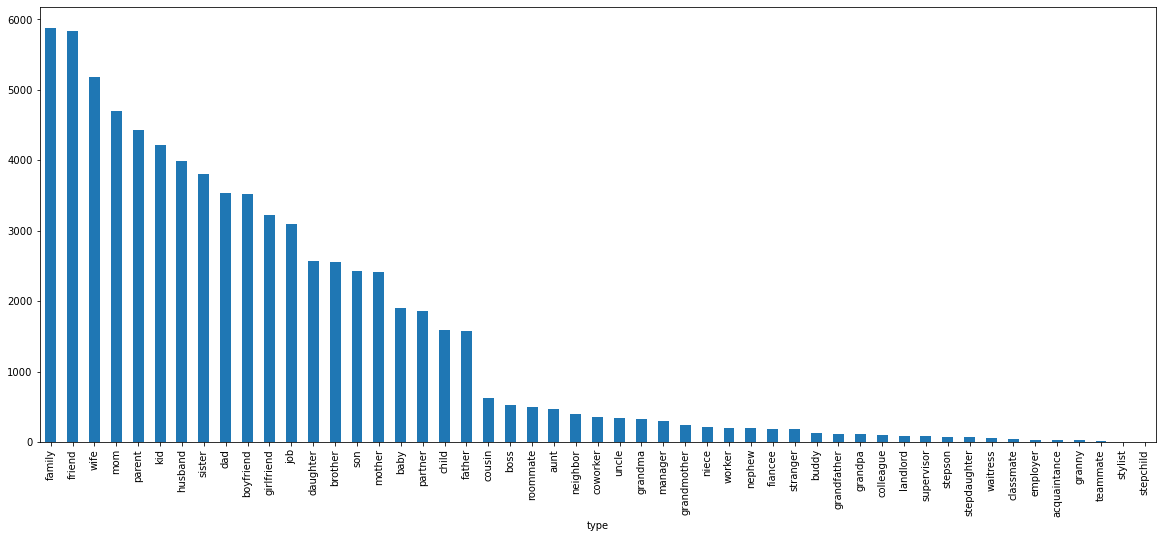

In [135]:
df['type'].value_counts().plot(kind='bar', figsize=(20,8))

In [136]:
df['type'].value_counts()

type
family          5881
friend          5830
wife            5185
mom             4705
parent          4425
kid             4225
husband         3984
sister          3813
dad             3542
boyfriend       3517
girlfriend      3227
job             3102
daughter        2565
brother         2559
son             2427
mother          2415
baby            1909
partner         1855
child           1589
father          1581
cousin           629
boss             532
roommate         492
aunt             468
neighbor         393
coworker         360
uncle            344
grandma          330
manager          300
grandmother      248
niece            215
worker           205
nephew           202
fiancee          186
stranger         180
buddy            134
grandfather      121
grandpa          114
colleague        100
landlord          89
supervisor        83
stepson           78
stepdaughter      75
waitress          63
classmate         43
employer          33
acquaintance      27
granny  